In [2]:
# imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import geodatasets
from pathlib import Path
from matplotlib import font_manager
from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML
import matplotlib.cm as cm
from matplotlib import colormaps

# data folder
data_folder = '../01_data/'
figure_folder = '../04_documents/02_supplement_figures/'

# input data
annual_metrics = pd.read_csv(Path(data_folder) / '04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv')

In [4]:
# Total population range
pop_min = egypt_data["total_pop"].min()
pop_max = egypt_data["total_pop"].max()

# Total demographic rate (total_dr) range
dr_min = egypt_data["total_dr"].min()
dr_max = egypt_data["total_dr"].max()

print(f"Total population range: {pop_min} to {pop_max}")
print(f"Total DR range: {dr_min} to {dr_max}")


Total population range: 0.0 to 19756306.71875
Total DR range: 0.2212231750829883 to 1.0287276704909607


In [5]:
df_country = annual_metrics[annual_metrics['Country'] == country_to_plot].copy()
df_country = df_country.sort_values('year')


NameError: name 'country_to_plot' is not defined

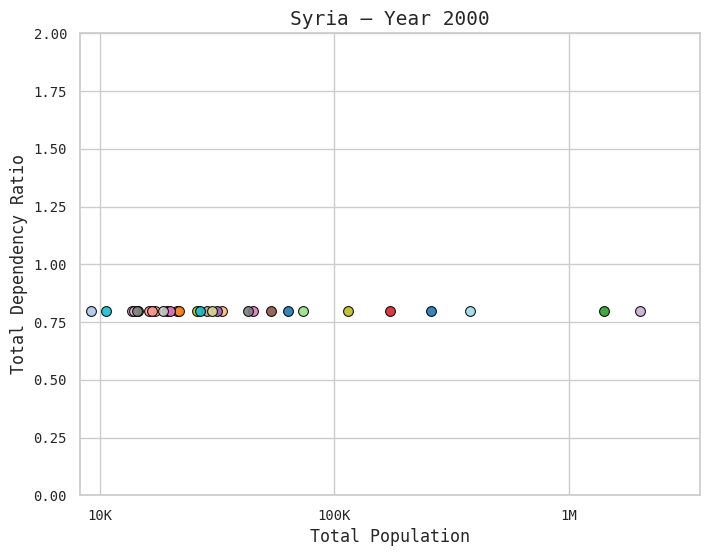

In [6]:
# -----------------------------
# SETTINGS
# -----------------------------
country_to_plot = "Syria"  # Replace with your country
mono_font = font_manager.FontProperties(family="DejaVu Sans Mono")
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8,6))

# -----------------------------
# FILTER DATA
# -----------------------------
df_country = annual_metrics[annual_metrics['Country'] == country_to_plot].copy()
df_country = df_country.sort_values('year')
df_country = df_country[df_country['total_pop'] > 0]

years = df_country['year'].unique()
locations = df_country['ID_UC_G0'].unique()

# -----------------------------
# ASSIGN UNIQUE COLORS TO EACH LOCATION
# -----------------------------
cmap = colormaps.get_cmap("tab20")  # no second argument
colors_list = [cmap(i / len(locations)) for i in range(len(locations))]
color_map = {loc: colors_list[i] for i, loc in enumerate(locations)}

# -----------------------------
# LOG FORMATTER FOR POPULATION
# -----------------------------
def human_format(x, pos):
    if x >= 1_000_000_000:
        return f"{int(x/1_000_000_000)}B"
    elif x >= 1_000_000:
        return f"{int(x/1_000_000)}M"
    elif x >= 1_000:
        return f"{int(x/1_000)}K"
    else:
        return str(int(x))

formatter = FuncFormatter(human_format)

# -----------------------------
# INITIAL AXIS SETUP
# -----------------------------
ax.set_xscale('log')
ax.set_xlabel("Total Population", fontproperties=mono_font, fontsize=12)
ax.set_ylabel("Total Dependency Ratio", fontproperties=mono_font, fontsize=12)
ax.set_title(f"{country_to_plot}: Total Population vs Dependency Ratio", fontproperties=mono_font, fontsize=14)
ax.set_xlim(df_country['total_pop'].min()*0.9, df_country['total_pop'].max()*1.1)
ax.set_ylim(0, 2)
ax.xaxis.set_major_formatter(formatter)

for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(10)

# -----------------------------
# ANIMATION FUNCTION WITH TRAILS
# -----------------------------
def update(frame):
    year = years[frame]
    past_data = df_country[df_country['year'] <= year]
    current_data = df_country[df_country['year'] == year]
    
    ax.clear()
    
    # -----------------
    # PAST POINTS (trail)
    # -----------------
    for loc in past_data['ID_UC_G0'].unique():
        loc_data = past_data[past_data['ID_UC_G0'] == loc]
        if len(loc_data) > 1:
            # all past except the last/current
            trail_data = loc_data.iloc[:-1]
            ax.scatter(
                trail_data['total_pop'],
                trail_data['total_dr'],
                s=10,  # smaller
                color=color_map[loc],
                alpha=0.3,  # more faded
                edgecolor='black',
                linewidth=0.4
            )
    
    # -----------------
    # CURRENT POINTS
    # -----------------
    for loc in current_data['ID_UC_G0'].unique():
        loc_data = current_data[current_data['ID_UC_G0'] == loc]
        ax.scatter(
            loc_data['total_pop'],
            loc_data['total_dr'],
            s=50,
            color=color_map[loc],
            edgecolor='black',
            linewidth=0.8,
            alpha=0.9
        )
    
    # -----------------
    # AXES
    # -----------------
    ax.set_xscale('log')
    ax.set_xlabel("Total Population", fontproperties=mono_font, fontsize=12)
    ax.set_ylabel("Total Dependency Ratio", fontproperties=mono_font, fontsize=12)
    ax.set_title(f"{country_to_plot} — Year {year}", fontproperties=mono_font, fontsize=14)
    ax.set_xlim(df_country['total_pop'].min()*0.9, df_country['total_pop'].max()*1.1)
    ax.set_ylim(0, 2)
    ax.xaxis.set_major_formatter(formatter)
    
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(10)

# -----------------------------
# CREATE ANIMATION
# -----------------------------
anim = FuncAnimation(fig, update, frames=len(years), interval=1000, repeat=True)

# -----------------------------
# DISPLAY INLINE IN JUPYTER
# -----------------------------
HTML(anim.to_jshtml())


In [9]:
import pandas as pd
import json
from pathlib import Path
from matplotlib import colormaps

# =====================================================
# OUTPUT
# =====================================================
output_html = Path("../03_documents/03_other_figures/interactive_population_animation.html")

# =====================================================
# PREP DATA
# =====================================================
country_data_dict = {}
countries = sorted(annual_metrics['Country'].dropna().unique())

for country in countries:
    df_country = annual_metrics[annual_metrics['Country'] == country].copy().sort_values("year")
    df_country = df_country[df_country['total_pop'] > 0]

    years = df_country['year'].astype(int).unique().tolist()
    locations = df_country['ID_UC_G0'].unique()
    cmap = colormaps.get_cmap("tab20")

    colors_list = [cmap(i/len(locations))[:3] for i in range(len(locations))]
    color_map = {str(loc): [float(c) for c in colors_list[i]] for i, loc in enumerate(locations)}

    records = []
    for _, row in df_country.iterrows():
        records.append({
            "year": int(row["year"]),
            "ID_UC_G0": str(row["ID_UC_G0"]),
            "total_pop": float(row["total_pop"]),
            "total_dr": float(row["total_dr"]),
            "Name": row["Name"]  # <-- change to your city name column
        })

    country_data_dict[country] = {
        "years": years,
        "data": records,
        "color_map": color_map
    }

country_data_json = json.dumps(country_data_dict)

# =====================================================
# HTML
# =====================================================
html = f"""
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<style>
body {{ font-family: "DejaVu Sans Mono", monospace; }}
button {{ font-family: "DejaVu Sans Mono", monospace; }}
</style>
</head>
<body>

<h2>Global Urban Demographic Dataset (GUDD) - Population vs Dependency Ratio</h2>

Country:
<select id="dropdown"></select>
&nbsp;&nbsp;
<button onclick="play()">Play</button>
<button onclick="pause()">Pause</button>
<button onclick="faster()">+</button>
<button onclick="slower()">-</button>
<br><br>

<canvas id="canvas" width="900" height="650" style="border:1px solid black"></canvas>

<script>
const FONT = "14px 'DejaVu Sans Mono', monospace";
const TITLE_FONT = "20px 'DejaVu Sans Mono', monospace";
const xTicks = [100,1000,10000,100000,1000000,10000000,100000000,1000000000];
const countryData = {country_data_json};

const canvas = document.getElementById("canvas");
const ctx = canvas.getContext("2d");
const dropdown = document.getElementById("dropdown");
const speedLabel = document.getElementById("speedLabel");

Object.keys(countryData).forEach(function(c) {{
    let opt = document.createElement("option");
    opt.value = c;
    opt.text = c;
    dropdown.appendChild(opt);
}});

let country = dropdown.value;
let frame = 0;
let speed = 300;
let running = true;
let lastTime = 0;

// hover info
let hover = {{x:0, y:0, text:"", active:false}};
let mouseX = 0, mouseY = 0;

canvas.addEventListener("mousemove", function(evt){{
    const rect = canvas.getBoundingClientRect();
    mouseX = evt.clientX - rect.left;
    mouseY = evt.clientY - rect.top;
}});

function play() {{ running=true; }}
function pause() {{ running=false; }}
function faster() {{ speed=Math.max(50,speed-50); speedLabel.innerText = speed+" ms"; }}
function slower() {{ speed+=50; speedLabel.innerText = speed+" ms"; }}

function humanFormat(x){{
    if(x>=1e9) return "1B";
    if(x>=1e6) return (x/1e6)+"M";
    if(x>=1e3) return (x/1e3)+"K";
    return x;
}}

function drawAxes(xMin,xMax,padding){{
    ctx.font = FONT;
    ctx.fillStyle = "black";
    ctx.strokeStyle = "black";
    const yMin = 0;
    const yMax = 2;

    ctx.beginPath();
    ctx.moveTo(padding,padding);
    ctx.lineTo(padding,600-padding);
    ctx.lineTo(900-padding,600-padding);
    ctx.stroke();

    ctx.strokeStyle="rgba(0,0,0,0.1)";
    ctx.textAlign="right";
    ctx.textBaseline="middle";
    for(let y=0;y<=2;y+=0.2){{
        let py = 600-padding-(y-yMin)/(yMax-yMin)*(600-2*padding);
        ctx.beginPath();
        ctx.moveTo(padding,py);
        ctx.lineTo(900-padding,py);
        ctx.stroke();
        ctx.fillStyle="black";
        ctx.fillText(y.toFixed(1),padding-5,py);
    }}

    ctx.textAlign="center";
    ctx.textBaseline="top";
    xTicks.forEach(function(val){{
        if(val<xMin||val>xMax) return;
        let px = padding+(Math.log10(val)-Math.log10(xMin))/(Math.log10(xMax)-Math.log10(xMin))*(900-2*padding);
        ctx.beginPath();
        ctx.moveTo(px,padding);
        ctx.lineTo(px,600-padding);
        ctx.stroke();
        ctx.fillStyle="black";
        ctx.fillText(humanFormat(val),px,600-padding+5);
    }});

    ctx.font = FONT;
    ctx.save();
    ctx.translate(25,300);
    ctx.rotate(-Math.PI/2);
    ctx.fillText("Total Dependency Ratio",0,0);
    ctx.restore();
    ctx.fillText("Total Population",450,590);
}}

if (!CanvasRenderingContext2D.prototype.roundRect) {{
    CanvasRenderingContext2D.prototype.roundRect = function(x,y,w,h,r){{
        if(r===undefined) r=5;
        this.beginPath();
        this.moveTo(x+r,y);
        this.lineTo(x+w-r,y);
        this.quadraticCurveTo(x+w,y,x+w,y+r);
        this.lineTo(x+w,y+h-r);
        this.quadraticCurveTo(x+w,y+h,x+w-r,y+h);
        this.lineTo(x+r,y+h);
        this.quadraticCurveTo(x,y+h,x,y+h-r);
        this.lineTo(x,y+r);
        this.quadraticCurveTo(x,y,x+r,y);
        this.closePath();
    }};
}}

function draw(timestamp){{
    requestAnimationFrame(draw);

    if(running && timestamp - lastTime < speed) return;
    if(running) lastTime = timestamp;

    ctx.clearRect(0,0,900,600);
    const padding = 80;
    const data = countryData[country].data;
    const years = countryData[country].years;
    const colorMap = countryData[country].color_map;
    const year = years[frame%years.length];
    const pops = data.map(d=>d.total_pop);
    const xMin = Math.min(...pops)*0.9;
    const xMax = Math.max(...pops)*1.1;

    drawAxes(xMin,xMax,padding);

    hover.active=false;

    // draw points
    data.forEach(function(d){{
        if(d.year>year) return;
        let x = padding + (Math.log10(d.total_pop)-Math.log10(xMin))/(Math.log10(xMax)-Math.log10(xMin))*(900-2*padding);
        let y = 600-padding-(d.total_dr)/2*(600-2*padding);
        let color = colorMap[d.ID_UC_G0];
        let alpha = d.year==year?0.75:0.25;
        let size = d.year==year?6:3;

        ctx.beginPath();
        ctx.fillStyle = "rgba(" + Math.floor(color[0]*255) + "," + Math.floor(color[1]*255) + "," + Math.floor(color[2]*255) + "," + alpha + ")";
        ctx.arc(x,y,size,0,6.28);
        ctx.fill();
        ctx.stroke();

        // hover detection
        if(Math.hypot(mouseX-x, mouseY-y)<5){{
            hover.active = true;
            hover.x = x;
            hover.y = y;
            hover.text = d.Name;
        }}
    }});

    // draw hover label
    if(hover.active){{
        ctx.font = FONT;
        const paddingBox = 6;
        const textWidth = ctx.measureText(hover.text).width;
        const textHeight = 20; // increased from 16 to make box taller
        const boxX = hover.x - textWidth/2 - paddingBox;
        const boxY = hover.y - textHeight/2 - paddingBox;
        const boxW = textWidth + 2*paddingBox;
        const boxH = textHeight + 2*paddingBox;

        ctx.fillStyle = "lightgray";
        ctx.strokeStyle = "black";
        ctx.lineWidth = 1;
        ctx.beginPath();
        ctx.roundRect(boxX, boxY, boxW, boxH, 4);
        ctx.fill();
        ctx.stroke();

        ctx.fillStyle = "black";
        ctx.textAlign = "center";
        ctx.textBaseline = "middle";
        ctx.fillText(hover.text, hover.x, hover.y);
    }}

    // title
    ctx.font = TITLE_FONT;
    ctx.fillStyle = "black";
    ctx.textAlign = "center";
    ctx.fillText(country+" "+year,450,40);

    if(running) frame++;
}}

dropdown.onchange = function(){{ country = dropdown.value; frame=0; }};
requestAnimationFrame(draw);
</script>

</body>
</html>
"""

output_html.write_text(html)
print("Saved:", output_html)


Saved: ../03_documents/03_other_figures/interactive_population_animation.html


# Plot a single .gif

Saved GIF: ../03_documents/03_other_figures/Ghana_population_dependency_ratio.gif


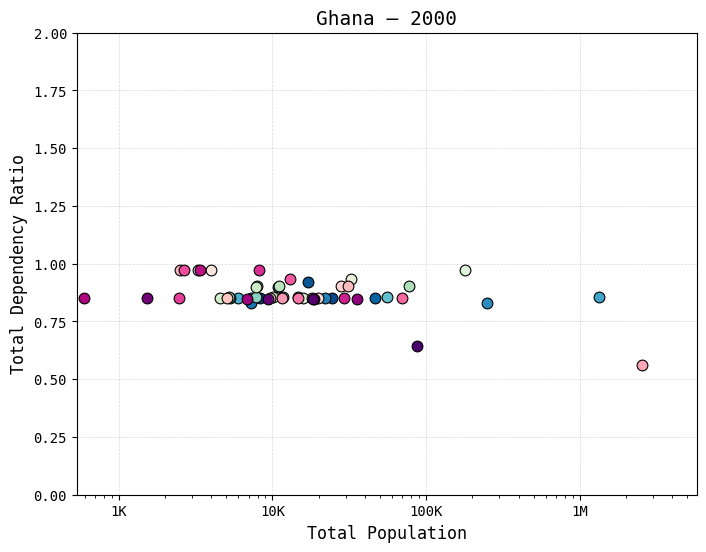

In [7]:
# ============================================================
# GIF ANIMATION — POPULATION VS DEPENDENCY RATIO (SINGLE COUNTRY)
# Each city gets a unique color from your custom palette
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import font_manager
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# -----------------------------
# SETTINGS
# -----------------------------
country_to_plot = "Ghana"

data_folder = Path("../01_data/")
output_folder = Path("../03_documents/03_other_figures/")
output_folder.mkdir(parents=True, exist_ok=True)
output_gif = output_folder / f"{country_to_plot}_population_dependency_ratio.gif"

nat_colors = [
    '#084081','#0868ac','#2b8cbe','#4eb3d3',
    '#7bccc4','#a8ddb5','#ccebc5','#e0f3db'
]
mig_colors = [
    '#fde0dd','#fcc5c0','#fa9fb5','#f768a1',
    '#dd3497','#ae017e','#7a0177','#49006a'
]
full_colors = nat_colors + mig_colors

mono_font = font_manager.FontProperties(family="DejaVu Sans Mono")

# -----------------------------
# LOAD DATA
# -----------------------------
annual_metrics = pd.read_csv(
    data_folder / "04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv"
)

df_country = annual_metrics[annual_metrics["Country"] == country_to_plot].copy()
df_country = df_country[df_country["total_pop"] > 0].sort_values("year")

years = sorted(df_country["year"].unique())
locations = sorted(df_country["ID_UC_G0"].unique())
pop_min = df_country["total_pop"].min()
pop_max = df_country["total_pop"].max()

# -----------------------------
# ASSIGN COLORS TO LOCATIONS
# -----------------------------
if len(locations) > len(full_colors):
    cmap = LinearSegmentedColormap.from_list("custom", full_colors)
    colors_list = [cmap(i/(len(locations)-1)) for i in range(len(locations))]
else:
    colors_list = full_colors[:len(locations)]
color_map = dict(zip(locations, colors_list))

# -----------------------------
# POPULATION FORMATTER
# -----------------------------
def human_format(x, pos):
    if x >= 1e9: return f"{int(x/1e9)}B"
    if x >= 1e6: return f"{int(x/1e6)}M"
    if x >= 1e3: return f"{int(x/1e3)}K"
    return str(int(x))

formatter = FuncFormatter(human_format)

# -----------------------------
# CREATE FIGURE
# -----------------------------
fig, ax = plt.subplots(figsize=(8,6))

# -----------------------------
# UPDATE FUNCTION
# -----------------------------
def update(frame):
    year = years[frame]
    ax.clear()  # only once at start

    # Past and current data
    past = df_country[df_country["year"] <= year]
    current = df_country[df_country["year"] == year]

    # -----------------------------
    # AXES AND GRID
    # -----------------------------
    ax.set_xscale("log")
    ax.set_xlim(pop_min*0.9, pop_max*1.1)
    ax.set_ylim(0, 2)
    ax.set_xlabel("Total Population", fontproperties=mono_font, fontsize=12)
    ax.set_ylabel("Total Dependency Ratio", fontproperties=mono_font, fontsize=12)
    ax.set_title(f"{country_to_plot} — {year}", fontproperties=mono_font, fontsize=14)
    ax.xaxis.set_major_formatter(formatter)

    # Faint x and y grid lines
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(10)

    # -----------------------------
    # TRAILS (past points)
    # -----------------------------
    for loc in locations:
        loc_data = past[past["ID_UC_G0"] == loc]
        if len(loc_data) > 1:
            trail = loc_data.iloc[:-1]
            ax.scatter(
                trail["total_pop"],
                trail["total_dr"],
                s=12,
                color=color_map[loc],
                alpha=0.25,
                edgecolor="black",
                linewidth=0.3
            )

    # -----------------------------
    # CURRENT POINTS
    # -----------------------------
    for loc in locations:
        loc_data = current[current["ID_UC_G0"] == loc]
        if len(loc_data) == 0:
            continue
        ax.scatter(
            loc_data["total_pop"],
            loc_data["total_dr"],
            s=60,
            color=color_map[loc],
            edgecolor="black",
            linewidth=0.8
        )

# -----------------------------
# CREATE ANIMATION
# -----------------------------
anim = FuncAnimation(fig, update, frames=len(years), interval=800, repeat=True)

# -----------------------------
# SAVE GIF
# -----------------------------
writer = PillowWriter(fps=1.2)
anim.save(output_gif, writer=writer, dpi=200)

print("Saved GIF:", output_gif)
